In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
day_path = 'Data/Day'
metadata = 'Data/idm_baru.csv'

In [14]:
idm_df = pd.read_csv(metadata)

idm_df.head()

,KABUPATEN,KECAMATAN,KODE BPS,DESA,IKS,IKE,IKL,IDM,KATEGORI IDM,BINARY STATUS
0,ACEH UTARA,SAWANG,1111010001,RISEH TUNONG,0.56,3667.00,3333.0,0.42,SANGAT TERTINGGAL,TERTINGGAL
1,ACEH UTARA,SAWANG,1111010002,GUNCI,7029.00,4167.00,3333.0,4843.00,SANGAT TERTINGGAL,TERTINGGAL
2,ACEH UTARA,SAWANG,1111010003,KUBU,6914.00,4667.00,4667.0,5416.00,TERTINGGAL,TERTINGGAL
3,ACEH UTARA,SAWANG,1111010004,BLANG CUT,6514.00,3333.00,4667.0,4838.00,SANGAT TERTINGGAL,TERTINGGAL
4,ACEH UTARA,SAWANG,1111010005,RISEH TEUNGOH,5714.00,0.45,5333.0,5183.00,TERTINGGAL,TERTINGGAL


In [12]:
idm_df_filtered = idm_df[['KODE BPS', 'KECAMATAN', 'DESA', 'BINARY STATUS']]
idm_df_filtered

,KODE BPS,KECAMATAN,DESA,BINARY STATUS
0,1111010001,SAWANG,RISEH TUNONG,TERTINGGAL
1,1111010002,SAWANG,GUNCI,TERTINGGAL
2,1111010003,SAWANG,KUBU,TERTINGGAL
3,1111010004,SAWANG,BLANG CUT,TERTINGGAL
4,1111010005,SAWANG,RISEH TEUNGOH,TERTINGGAL
...,...,...,...,...
846,1111041003,GEUREDONG PASE,KRUENG MBANG,TERTINGGAL
847,1111041002,GEUREDONG PASE,PULO MEURIA,TERTINGGAL
848,1111041001,GEUREDONG PASE,SUKA DAMAI,MAJU
849,1111022002,BANDA BARO,ALUE KEURINYAI,MAJU


In [17]:
def match_images_with_metadata(image_files, metadata):
    image_data = []
    
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        village_code = img_name.split('-')[0]
        village_info = metadata[metadata['KODE BPS'] == int(village_code)]
        if not village_info.empty:
            kecamatan = village_info['KECAMATAN'].values[0]
            desa = village_info['DESA'].values[0]
            status = village_info['BINARY STATUS'].values[0]
            image_data.append({
                'filename': img_name,
                'filepath': img_path,
                'kecamatan': kecamatan,
                'desa': desa,
                'status': status
            })
    
    return pd.DataFrame(image_data)

In [10]:
day_files = []
for root, dirs, files in os.walk(day_path):
    for file in files:
        day_files.append(os.path.join(root, file))

day_files[:10]

['Data/Day\\MAJU\\1111010008-l.png',
 'Data/Day\\MAJU\\1111010008-s.png',
 'Data/Day\\MAJU\\1111010023-l.png',
 'Data/Day\\MAJU\\1111010023-s.png',
 'Data/Day\\MAJU\\1111010024-l.png',
 'Data/Day\\MAJU\\1111010024-s.png',
 'Data/Day\\MAJU\\1111010027-l.png',
 'Data/Day\\MAJU\\1111010027-s.png',
 'Data/Day\\MAJU\\1111010034-l.png',
 'Data/Day\\MAJU\\1111010034-s.png']

In [19]:
day_images_metadata = match_images_with_metadata(day_files, idm_df_filtered)
day_images_metadata

,filename,filepath,kecamatan,desa,status
0,1111010008-l.png,Data/Day\MAJU\1111010008-l.png,SAWANG,SAWANG,MAJU
1,1111010008-s.png,Data/Day\MAJU\1111010008-s.png,SAWANG,SAWANG,MAJU
2,1111010023-l.png,Data/Day\MAJU\1111010023-l.png,SAWANG,MEUNASAH PULO,MAJU
3,1111010023-s.png,Data/Day\MAJU\1111010023-s.png,SAWANG,MEUNASAH PULO,MAJU
4,1111010024-l.png,Data/Day\MAJU\1111010024-l.png,SAWANG,LHOK KUYUN,MAJU
...,...,...,...,...,...
1697,1111170010-s.png,Data/Day\TERTINGGAL\1111170010-s.png,DEWANTARA,GEULUMPANG SULU BARAT,TERTINGGAL
1698,1111170014-l.png,Data/Day\TERTINGGAL\1111170014-l.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1699,1111170014-s.png,Data/Day\TERTINGGAL\1111170014-s.png,DEWANTARA,BANGKA JAYA,TERTINGGAL
1700,1111170015-l.png,Data/Day\TERTINGGAL\1111170015-l.png,DEWANTARA,BLUKA TEUBAI,TERTINGGAL


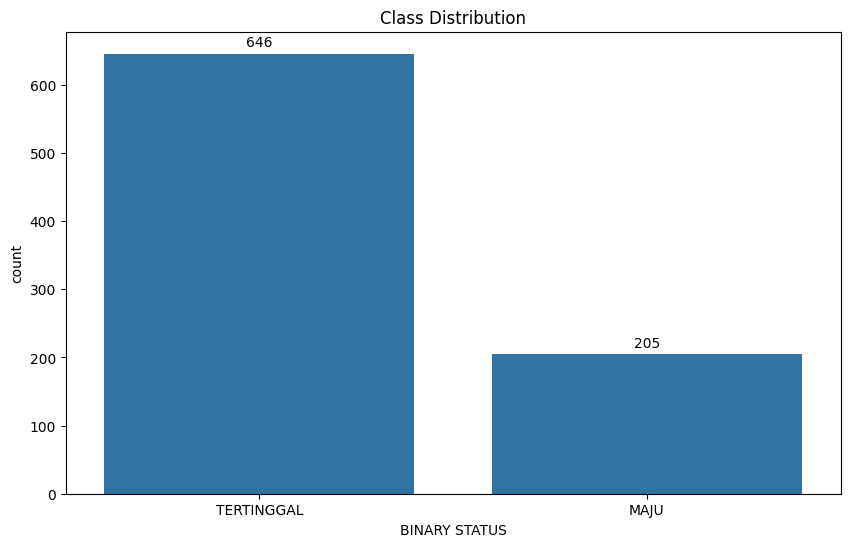

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='BINARY STATUS', data=idm_df_filtered)
plt.title('Class Distribution')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

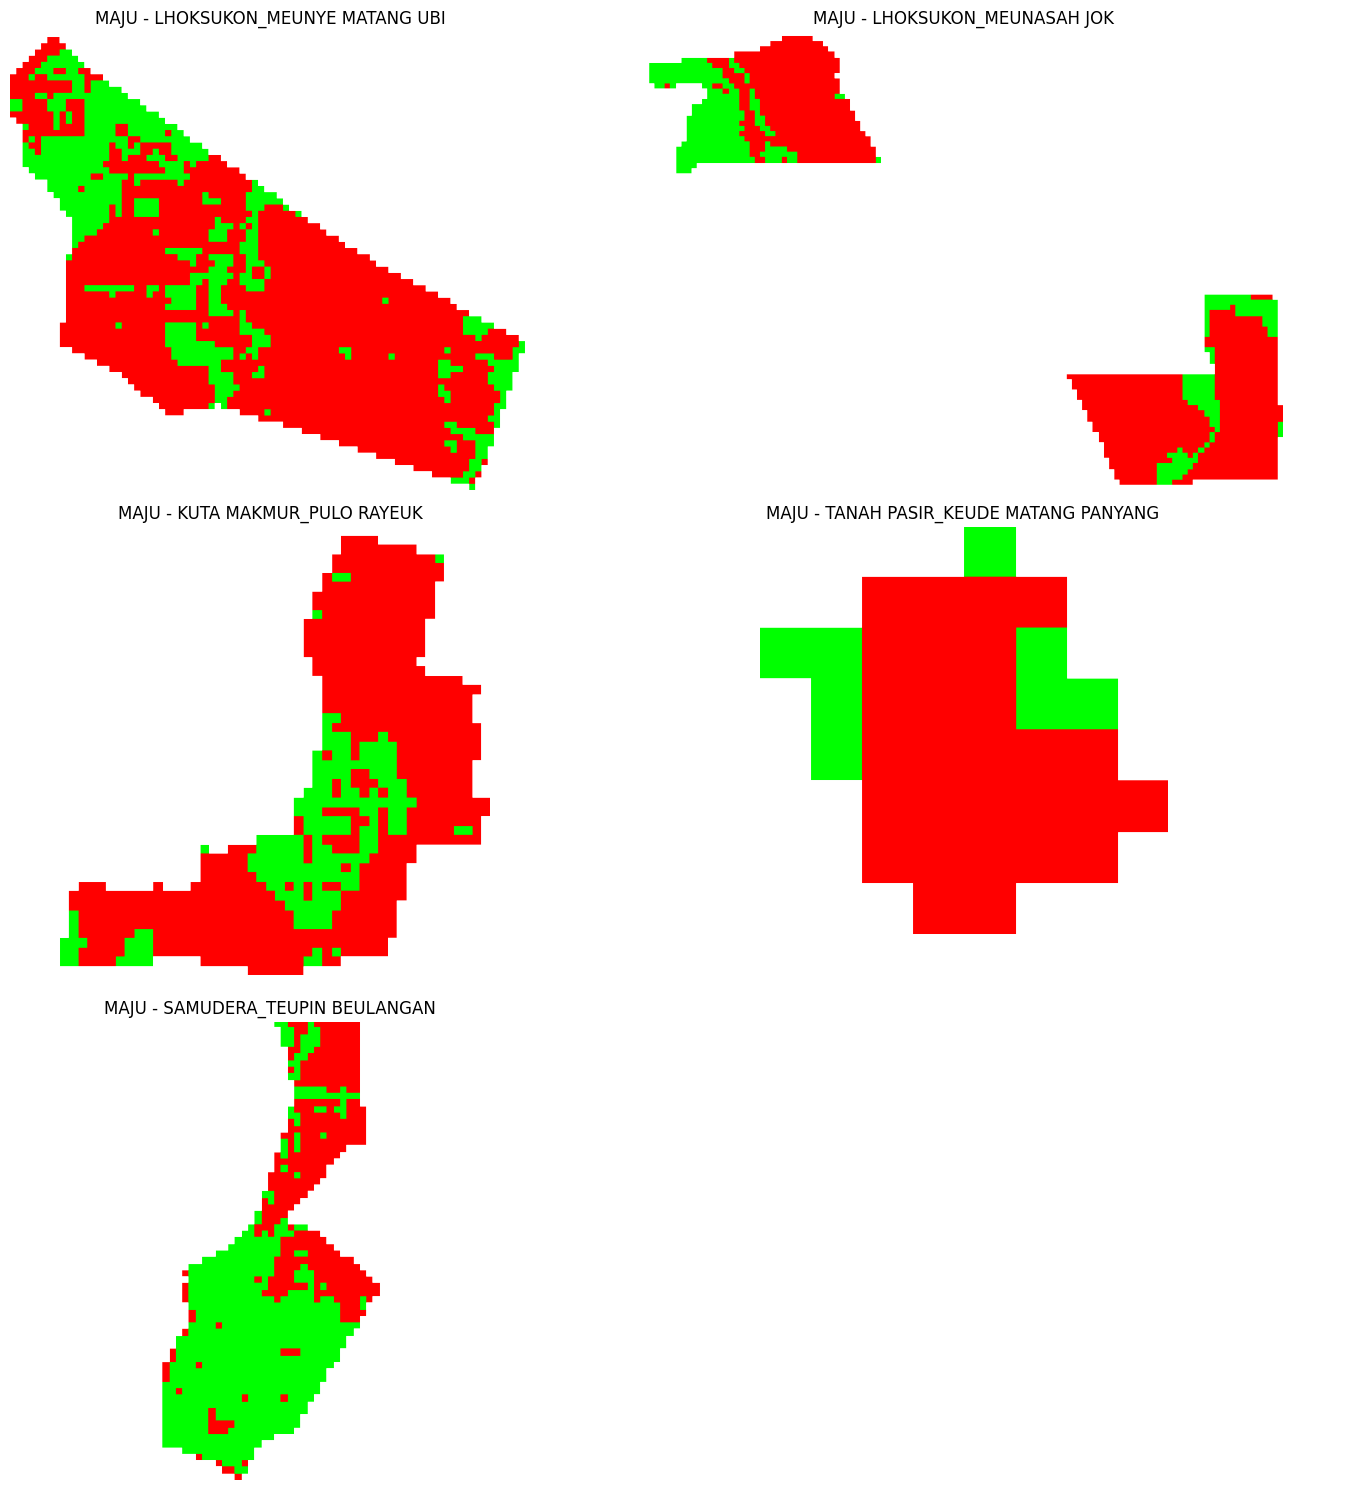

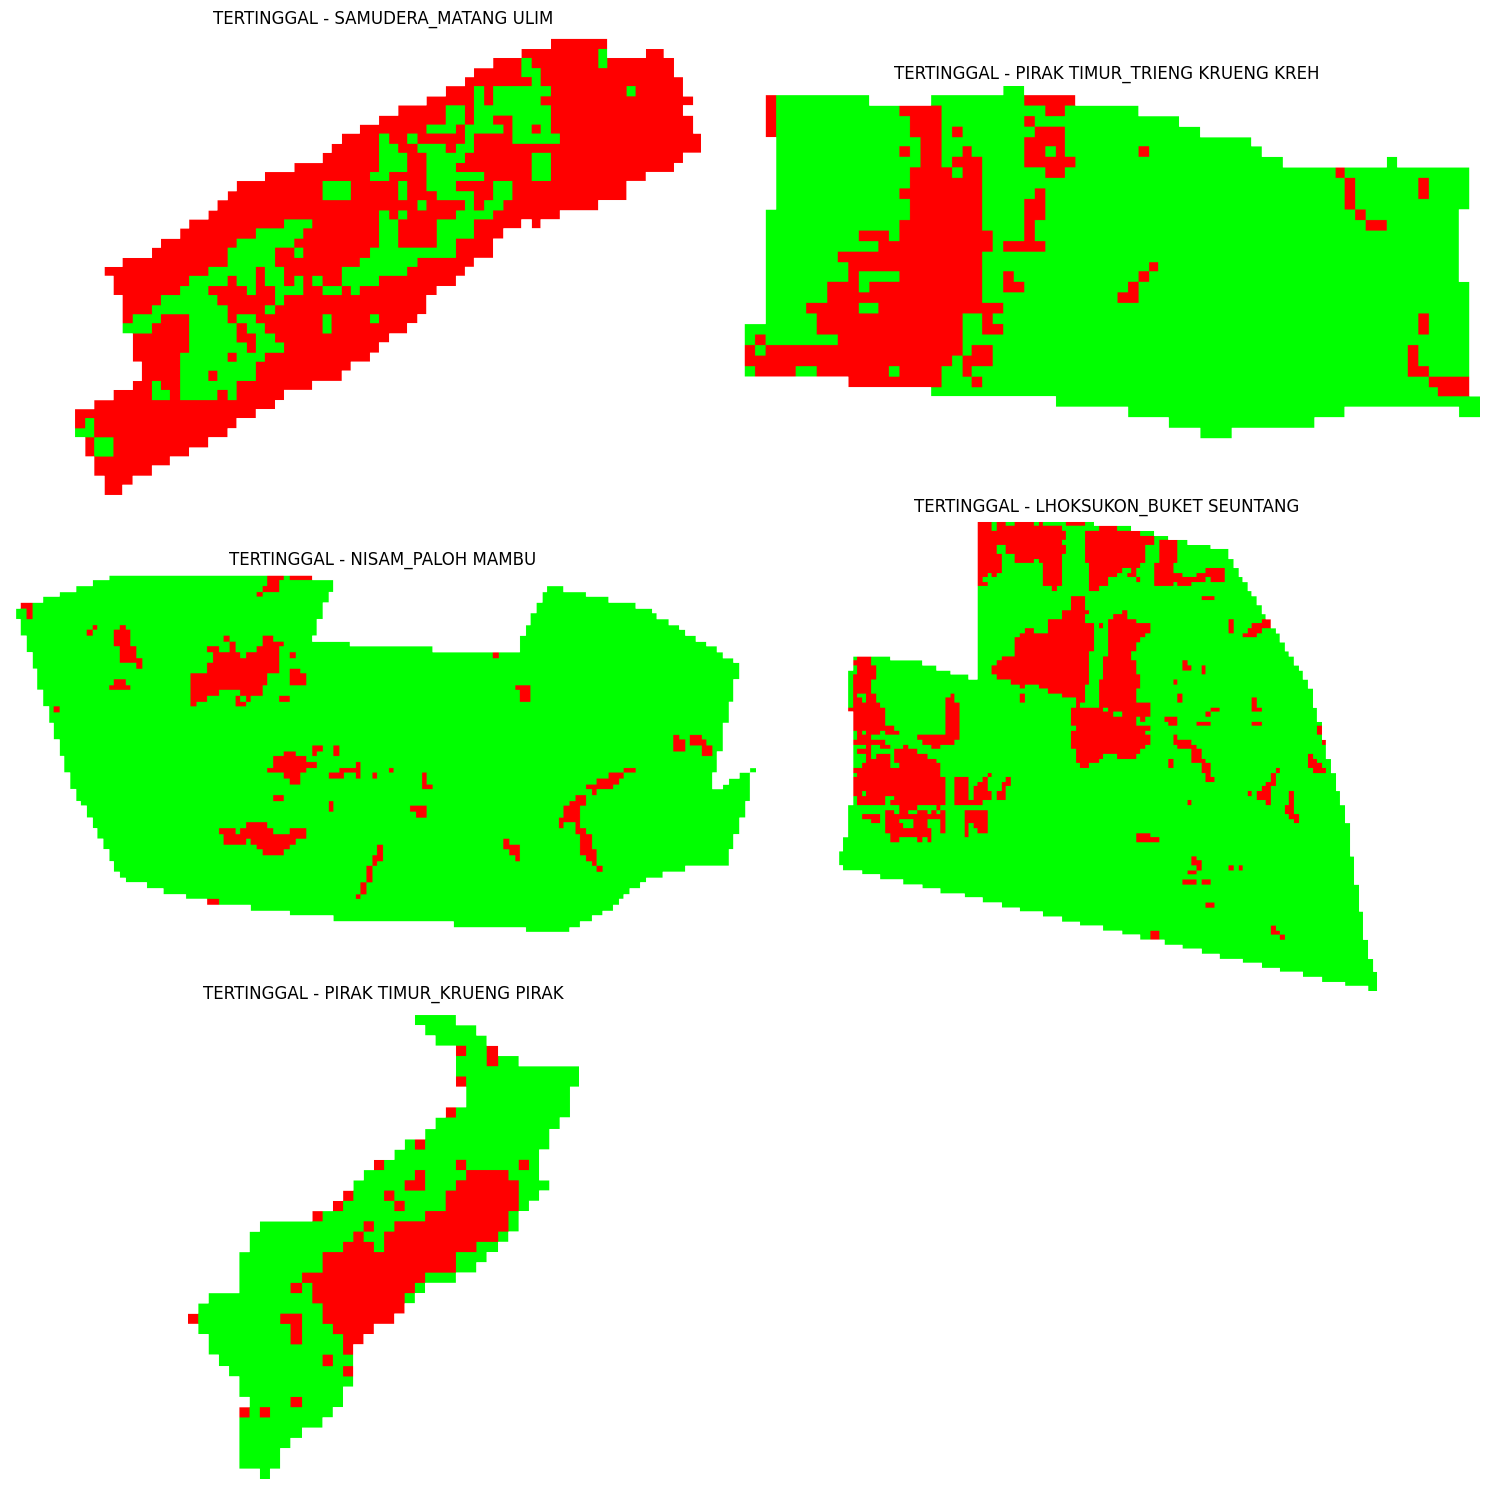

In [26]:
def show_sample_images(image_data, class_label, n=5, cols=2):
    class_images = image_data[image_data['status'] == class_label]
    sample_images = class_images.sample(n)
    
    rows = (n // cols) + (n % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample_images.iterrows()):
        img_path = row['filepath']
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"{class_label} - {row['kecamatan']}_{row['desa']}")
        ax.axis('off')
    
    for ax in axes[n:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(day_images_metadata, 'MAJU', n=5, cols=2)
show_sample_images(day_images_metadata, 'TERTINGGAL', n=5, cols=2)